In [12]:
from obspy import read
import numpy as np
from scipy.signal import hilbert
import matplotlib.pyplot as plt

# Ruta al archivo .mseed
data_directory = '../../data/lunar/training/data/S12_GradeA/xa.s12.00.mhz.1975-04-12HR00_evid00191.mseed' #peticion
mseed_file = f'{data_directory}'

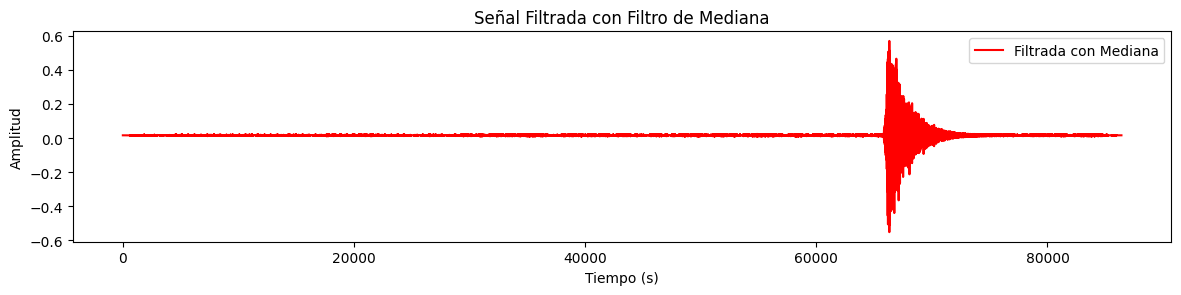

In [13]:
from scipy.signal import medfilt, savgol_filter
import matplotlib.pyplot as plt
import numpy as np
from obspy import read

# Leer el archivo mseed
st = read(mseed_file)
tr = st[0].copy()  # Obtener la primera traza

# Aplicar el filtro de banda
minfreq = 0.5
tr.filter('highpass', freq=minfreq)

# Obtener datos de la traza filtrada
tr_times = tr.times()
tr_data = tr.data

# Normalización Min-Max
min_val = np.min(tr_data)
max_val = np.max(tr_data)
tr_data_minmax = 2 * (tr_data - min_val) / (max_val - min_val) - 1  # Escalado entre -1 y 1

# 1. Aplicar un Filtro de Mediana
tr_data_median_filtered = medfilt(tr_data_minmax, kernel_size=5) 

# Visualizar las señales
plt.figure(figsize=(12, 8))

# Señal Filtrada con Mediana
plt.subplot(3, 1,1)
plt.plot(tr_times, tr_data_median_filtered, 'r-', label='Filtrada con Mediana')
plt.title('Señal Filtrada con Filtro de Mediana')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.savefig('mediana.png')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
import noisereduce as nr
sample_rate = 1 / (tr_times[1] - tr_times[0])  # Calcular tasa de muestreo
signal_cleaned = nr.reduce_noise(y=tr_data_median_filtered, sr=sample_rate, time_mask_smooth_ms=40000)

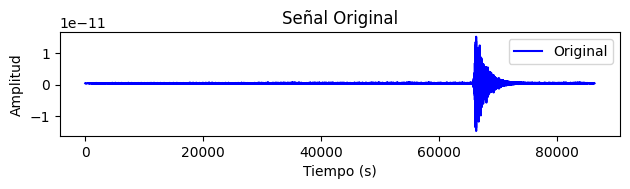

In [16]:
plt.subplot(3, 1, 1)
plt.plot(tr_times, signal_cleaned , 'b-', label='Original')
plt.title('Señal Original')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import ast

# Cadena a deserializar
data = '[(400,4000),"yes"]'

# Deserializar la cadena usando ast.literal_eval
deserialized_data = ast.literal_eval(data)

# Mostrar el resultado
print(deserialized_data)

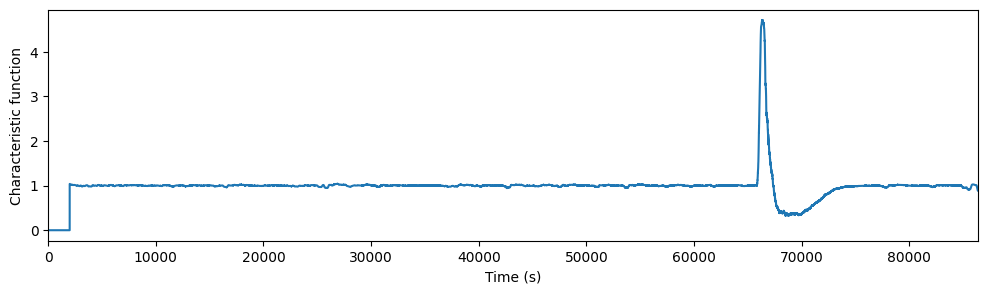

In [36]:
from obspy.signal.invsim import cosine_taper
from obspy.signal.filter import highpass
from obspy.signal.trigger import classic_sta_lta, plot_trigger, trigger_onset

# Sampling frequency of our trace
df = tr.stats.sampling_rate

# How long should the short-term and long-term window be, in seconds?
sta_len = 60
lta_len = 1200

# Run Obspy's STA/LTA to obtain a characteristic function
cft = classic_sta_lta(signal_cleaned, int(sta_len * df), int(lta_len * df))

# Definir el tiempo mínimo de duración de los eventos (en segundos)
min_duration = 420 # Puedes ajustarlo según tus necesidades

# Convertir el tiempo mínimo de duración a muestras
min_duration_samples = int(min_duration * df)
# Plot characteristic function
fig,ax = plt.subplots(1,1,figsize=(12,3))
ax.plot(tr_times,cft)
ax.set_xlim([min(tr_times),max(tr_times)])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Characteristic function')
plt.savefig('caracteristica.png')

Iteración 0: Probando con thr_on=10, thr_off=1
Iteración 1: Probando con thr_on=6, thr_off=1
Se encontraron eventos que cumplen la condición en la iteración 1 con thr_on=6 y thr_off=1.


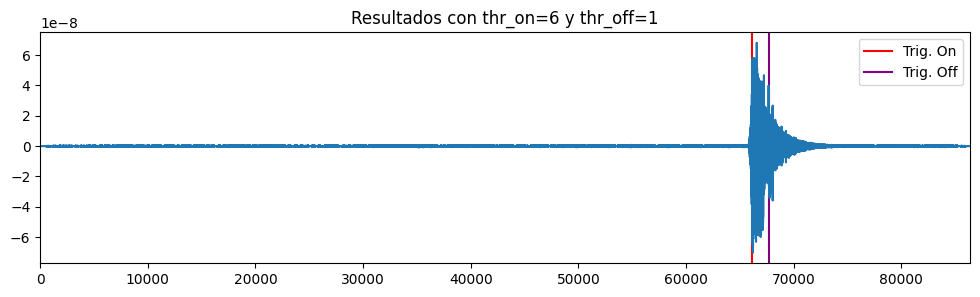

In [55]:
import numpy as np
import matplotlib.pyplot as plt

l_threshold_on = [12,10,6,5,4,1.8,1.5,1.1]  # Lista de umbrales de activación
l_threshold_off = [1,1,1,1,1,1,1,1]  # Lista de umbrales de desactivación

filtered_on_off = []  # Inicializar la lista que almacenará los eventos filtrados
idx = 0  # Inicializar el índice para las listas de umbrales

# Bucle while que se ejecuta hasta que se encuentre una lista no vacía de eventos
while len(filtered_on_off) == 0 and idx < len(l_threshold_on) :
    thr_on = l_threshold_on[idx]  # Obtener el umbral de activación actual
    thr_off = l_threshold_off[idx]  # Obtener el umbral de desactivación actual
    
    print(f"Iteración {idx}: Probando con thr_on={thr_on}, thr_off={thr_off}")
    
    # Obtener los triggers usando los umbrales actuales
    on_off = np.array(trigger_onset(cft, thr_on, thr_off))
    
    # Filtrar los eventos que duran menos que el tiempo mínimo
    filtered_on_off = []
    for triggers in on_off:
        if (triggers[1] - triggers[0]) >= min_duration_samples:
            filtered_on_off.append(triggers)
    
    # Convertir la lista filtrada de nuevo a un array de NumPy
    filtered_on_off = np.array(filtered_on_off)

    # Incrementar el índice para probar el siguiente conjunto de umbrales en caso de que no se haya encontrado ningún evento
    idx += 1

# Si se han encontrado eventos, se grafica
if len(filtered_on_off) > 0:
    print(f"Se encontraron eventos que cumplen la condición en la iteración {idx-1} con thr_on={l_threshold_on[idx-1]} y thr_off={l_threshold_off[idx-1]}.")

    # Plot on and off triggers (solo los filtrados)
    fig, ax = plt.subplots(1, 1, figsize=(12, 3))
    
    for i in np.arange(0, len(filtered_on_off)):
        triggers = filtered_on_off[i]
        ax.axvline(x=tr_times[triggers[0]], color='red', label='Trig. On' if i == 0 else "")
        ax.axvline(x=tr_times[triggers[1]], color='purple', label='Trig. Off' if i == 0 else "")
    
    # Plot seismogram
    ax.plot(tr_times, tr_data)
    ax.set_xlim([min(tr_times), max(tr_times)])
    
    # Manejar leyenda sin duplicados
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())
    
    plt.title(f"Resultados con thr_on={l_threshold_on[idx-1]} y thr_off={l_threshold_off[idx-1]}")
    plt.show()
else:
    print("No se encontraron eventos que cumplan la duración mínima en ninguno de los umbrales.")

In [56]:
filtered_on_off#end point

array([[438327, 448615]], dtype=int64)

In [7]:
import os
from dotenv import load_dotenv

load_dotenv()  # Load environment variables from .env

gemini_api_key = os.getenv("API_KEY")

In [29]:
import google.generativeai as genai
import os

genai.configure(api_key=gemini_api_key)

In [44]:
sample_file = genai.upload_file(path="./caracteristica.png",
                            display_name="prueba")

In [56]:
model = genai.GenerativeModel("CosmicQuakesmodelV2")
print(model)

genai.GenerativeModel(
    model_name='models/CosmicQuakesmodelV2',
    generation_config={},
    safety_settings={},
    tools=None,
    system_instruction=None,
    cached_content=None
)
